In [2]:
import torch
import matplotlib.pyplot as plt
from methods.self_optimal_transport import SOT, log_sinkhorn

%reload_ext autoreload
%autoreload 2

# Self-Optimal Transport (SOT)

SOT can be used for tasks like clustering, anomaly detection, or feature extraction in machine learning. By understanding the internal structure of the data set in terms of how each point relates to others, one can derive meaningful insights or improve the performance of predictive models.

![SOT workflow](../images/sot_workflow.png)

### Terms
__Optimal Transport (OT)__
OT is a mathematical theory that deals with the problem of transforming one probability distribution into another in the most efficient way possible. The "self" in Self-Optimal Transport means that we have only one distribution.

![optimal_transport_matrix](../images/optimal_transport_matrix.png)

Think of two separate distributions as two different ways of allocating a certain quantity of mass. For instance, one distribution could represent the locations of various warehouses (each with a certain amount of goods), and the other could represent the locations of stores that need those goods. The term "mass" can be abstract in OT. It could represent probability, density, or any quantity that can be redistributed. The aim is to find the best way to move this mass from the "warehouse" distribution to the "store" distribution.

__Cost Matrix__
To determine what 'best' means, we define a cost matrix that specifies the cost of moving a unit of mass from any point in the first distribution to any point in the second. This cost can be calculated using different metrics (Euclidean or cosine distances in our case). The choice of metric depends on the nature of the data and the specific application.

__Sinkhorn Algorithm__
The Sinkhorn algorithm is used for efficiently solving the Optimal Transport problem, especially when the cost matrix is large. It iterates to find the transport plan that minimizes the overall cost of moving from the initial distribution to the target distribution.

It is used to compute an optimal _transport plan_ which is represented as a matrix where each entry corresponds to the amount of mass to move from a point in the first distribution to a point in the second distribution. (row is a supply point and column is a demand point) 
The transport plan is considered _optimal_ when it minimizes the total cost of moving all the mass from the first distribution to satisfy the demands of the second distribution.

It is an iterative procedure that adjusts the elements of a matrix to make its rows and columns sum up to specified target vectors (usually probability distributions). The `log_sinkhorn` (used in code) is a variant that operates in log-space for improved numerical stability, especially when dealing with very small or very large numbers.
TODO go into the math [possible resource](https://personal.math.ubc.ca/~geoff/courses/W2019T1/Lecture13.pdf)



Let's go throught the code of SOT. The algorithm for computing SOT of feature matrix $V$ goes like this:

In [17]:
def __call__(self, X: torch.Tensor) -> torch.Tensor: # sot()
    """
    Compute the SOT features for X
    """
    # get masked cost matrix
    C = self.compute_cost(X=X)
    M = self.mask_diagonal(C, value=self.diagonal_val)

    # compute self-OT
    z_log = log_sinkhorn(M=M, reg=self.ot_reg, num_iters=self.sinkhorn_iterations)

    if self.sigmoid:
        z = torch.sigmoid(z_log)
    else:
        z = torch.exp(z_log)

    # divide the SOT matrix by its max to scale it up
    if self.max_scale:
        z_max = z.max().item() if z.dim() <= 2 else z.amax(dim=(1, 2), keepdim=True)
        z = z / z_max

    # set self-values to 1
    return self.mask_diagonal(z, value=1)

1. **Compute Cost Matrix** (`C`):
    The compute_cost function is called with the input tensor `X` to calculate the pairwise cost matrix `C`. This matrix represents the cost of "transporting" each feature in X to every other feature, according to the specified distance metric (e.g., Euclidean or cosine distance) normalized to `[0,1]`.
2. **Mask Diagonal** (`M`):
    The diagonal of the cost matrix `C` is then masked by setting the diagonal values to `self.diagonal_val`, which is typically a large value, using the mask_diagonal function. This discourages the algorithm from trivially transporting features to themselves in the optimization process.
3. **Compute Self-Optimal Transport** (`z_log`):
    The `log_sinkhorn` function is called with the masked cost matrix `M` to compute the Self-Optimal Transport plan in the log domain. This function iteratively adjusts the transport plan to minimize the overall cost, as constrained by the marginal distributions, resulting in a matrix `z_log` that represents the log domain solution to the OT problem.


4. **Apply Sigmoid or Exponential Function**:
    Depending on whether the sigmoid flag is set, the algorithm either applies the sigmoid function to `z_log` or exponentiates `z_log`. If sigmoid is true, `z = torch.sigmoid(z_log)` is used, effectively squashing the values to be between `0` and `1`. If sigmoid is false, `z = torch.exp(z_log)` is used, which converts the log probabilities back to a standard probability scale.

5. **Normalize the SOT Matrix**:
    If `self.max_scale` is true, the algorithm scales the entire SOT matrix z by dividing it by its maximum value. This is done to ensure that the values of `z` are in the range `[0, 1]`, which can be important for numerical stability and interpretability.

6. **Set Diagonal Values to 1**:
    Finally, the `mask_diagonal` function is used again to set the diagonal values of `z` to `1`. 
    Setting the diagonal entries of the SOT matrix to one after the Sinkhorn iterations is a form of normalization that reflects the notion of self-similarity, because each point is perfectly similar to itself. This step is commonly performed when the similarity matrix is intended to be used for further analysis or learning tasks where such an assumption is standard.
    TODO discuss why is it important for us

7. **Return the SOT Features**:
    The resulting tensor `z` is returned. It contains the SOT features for `X`, which now encode the pairwise similarities between the features in a way that has been optimized according to the transport plan.


In [21]:
sot = SOT(distance_metric='cosine', ot_reg=0.1, sinkhorn_iterations=10, sigmoid=False, mask_diag=True, max_scale=True) # defaults

In [19]:
n = 10 # number of features
d = 2  # dimension of features

V = torch.rand(n, d)  # features matrix
V

tensor([[0.4883, 0.5428],
        [0.5535, 0.5001],
        [0.2825, 0.0972],
        [0.2187, 0.1905],
        [0.3702, 0.9677],
        [0.0317, 0.0285],
        [0.0629, 0.7498],
        [0.5015, 0.9851],
        [0.5249, 0.8219],
        [0.9151, 0.3832]])

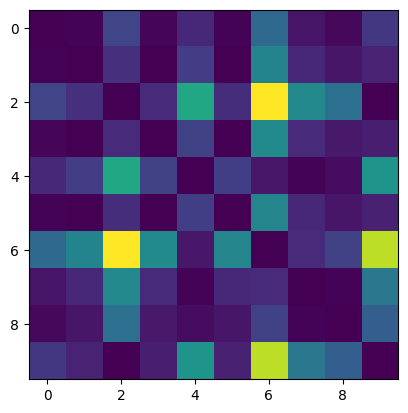

In [52]:
# compute the cost matrix
C = sot.compute_cost(V)
C_copy = C.clone()
plt.imshow(C.detach())

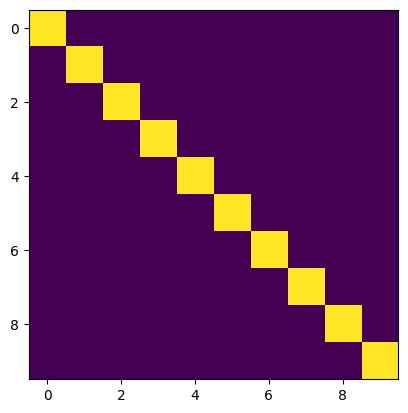

In [50]:
# mask diagonal 
M = sot.mask_diagonal(C,value=sot.diagonal_val)
plt.imshow(M.detach())

Text(0.5, 1.0, 'scaled exponential of z_log')

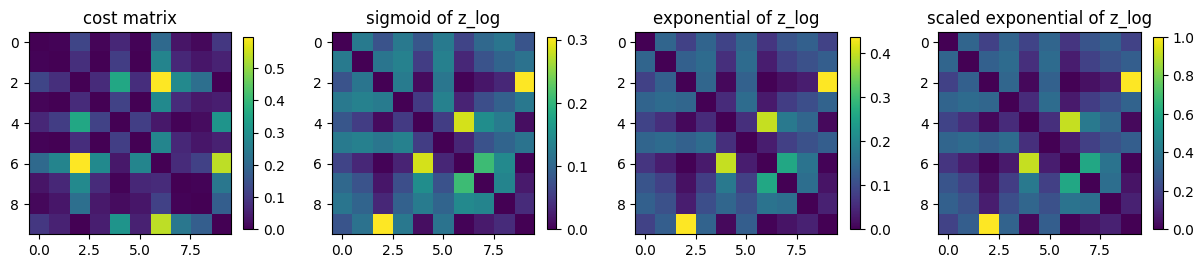

In [58]:
# compute the self-optimal transport in log domain using sinkhorns' algorithm
z_log = log_sinkhorn(M=M, reg=sot.ot_reg, num_iters=1000)
# sigmoid or exponenital
z_sig = torch.sigmoid(z_log)
z_exp = torch.exp(z_log) #default

fig,axs= plt.subplots(1,4,figsize=(15,5))
cax1 = axs[0].imshow(C_copy)
axs[0].set_title('cost matrix')
fig.colorbar(cax1, ax=axs[0],shrink=0.5)

cax2 = axs[1].imshow(z_sig)
axs[1].set_title('sigmoid of z_log')
fig.colorbar(cax2, ax=axs[1],shrink=0.5)

cax3 = axs[2].imshow(z_exp)
fig.colorbar(cax3, ax=axs[2],shrink=0.5)
axs[2].set_title('exponential of z_log')

# scale (default behaviour) if sot.max_scale
z = z_exp # default
z_max = z.max().item() if z.dim() <= 2 else z.amax(dim=(1, 2), keepdim=True)
z = z / z_max
cax4 = axs[3].imshow(z)
fig.colorbar(cax4, ax=axs[3],shrink=0.5)
axs[3].set_title('scaled exponential of z_log')

In [59]:
# set diagonal to one
out1 = sot.mask_diagonal(z, value=1)

In [60]:
out2 = sot(V)

In [77]:
import numpy as np
print(f"equal:{np.array_equal(out1,out2)}\nclose:{np.allclose(out1,out2)}\ndiff:{(out1-out2).abs().sum():.6}")

equal:False
close:True
diff:3.87942e-06


Let's see how SOT works on a simple example. We will generate a `n` feature vecotors of dimension `d` from two different normal distributions. We will then compute the SOT features and visualize them using PCA.

In [48]:
def generate_feature_vectors(n, d, mu1, sigma1, mu2, sigma2):
    # Generate n/2 samples from the first normal distribution
    samples1 = torch.normal(mu1, sigma1, (n//2, d))

    # Generate n/2 samples from the second normal distribution
    samples2 = torch.normal(mu2, sigma2, (n//2, d))

    # Combine the samples from both distributions
    samples = torch.cat((samples1, samples2))
    labels = torch.cat((torch.zeros(n//2), torch.ones(n//2)))
    return samples, labels

# Example usage
n = 1000 # Total number of feature vectors
d = 2    # Dimension of each vector
mu1, sigma1 = 0, 2  # Mean and standard deviation for the first distribution
mu2, sigma2 = 2, 5  # Mean and standard deviation for the second distribution

X,y = generate_feature_vectors(n, d, mu1, sigma1, mu2, sigma2)
print(f"X shape:{X.shape}\ny shape:{y.shape}")

X shape:torch.Size([1000, 2])
y shape:torch.Size([1000])


In [87]:
def generate_clusters(n, d, mus, sigmas):
    assert len(mus) == len(sigmas), "mus and sigmas must have the same length"
    assert n % len(mus) == 0, "n must be divisible by number of clusters (len(mus))"
    X = torch.empty((n, d))
    y = torch.empty(n)
    for i, (mu, sigma) in enumerate(zip(mus, sigmas)):
        start_index = i * n // len(mus)
        end_index = (i + 1) * n // len(mus)
        for j in range(d):
            mu_j = mu[j]
            sigma_j = sigma[j]
            X[start_index:end_index, j] = torch.normal(mu_j, sigma_j, (n // len(mus),))
        y[start_index:end_index] = i
    return X, y

# Example usage

d = 1000   # Dimension of each vector
k = 5    # Number of clusters
n = k*100  # Total number of feature vectors
mus = torch.rand(k, d)  # Means for the clusters
sigmas = torch.rand(k, d)*3  # Standard deviations for the clusters

X, y = generate_clusters(n, d, mus, sigmas)
print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: torch.Size([500, 1000])
y shape: torch.Size([500])


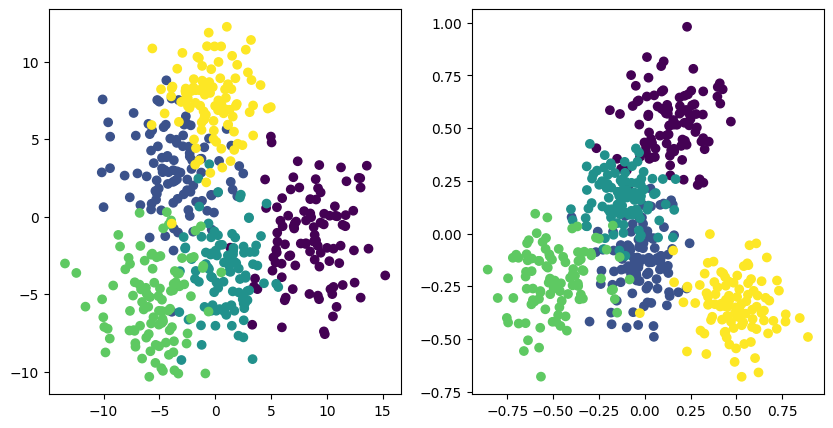

In [88]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np


sot = SOT(distance_metric='cosine', ot_reg=0.1, sinkhorn_iterations=10, sigmoid=False, mask_diag=True, max_scale=True) # defaults
pca = PCA(n_components=2)

a = pca.fit_transform(X)
b = pca.fit_transform(sot(X))
# tsne = TSNE(n_components=2,perplexity=10,learning_rate=100,random_state=42,verbose=1)
# b = tsne.fit_transform(out)

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(a[:,0],a[:,1],c=y)
axs[1].scatter(b[:,0],b[:,1],c=y)